In [1]:
using Revise
using Random
using ITensors
using RandomMeas
using ProgressMeter

## Shallow Shadows 
Based on https://quantum-journal.org/papers/q-2023-06-01-1026 and https://doi.org/10.1103/PhysRevResearch.5.023027 and arXiv:2402.17911

### Introduction
For a given set of random unitaries, the measurement channel is defined as $\mathcal{M}(\rho)=\sum_s \bra{s}u\rho u^\dagger \ket{s}E[u^\dagger \ket{s}\bra{s}u]$. To design a randomized measurement protocol, we need to learn this channel, then invert it. Once we know the inverse channel, we will be able to form shadows on arbitrary states $\rho$, as $\hat{\rho}=\mathcal{M}^{-1}(u^\dagger \ket{s}\bra{s}u)$

We begin by picking a set of $N_u$ unitaries and calculate numerically the measurement channel $\sigma_0=\mathcal{M}(\rho_0)$ from MPS simulations. Note that alternatively, one could consider measuring an approximate representation of the channel experimentally (arXiv:2402.17911)

In [35]:
#Step 1: Calibration Data acquisition
N = 12
ξ = siteinds("Qubit", N;addtags="output")
χ = 4
Nu = 1000
states = ["Dn" for n in 1:N]
ψ0 = MPS(ξ,states);
ρ0 = outer(ψ0',ψ0);

In [36]:
u = Vector{Vector{ITensor}}()
depth = 2
for r in 1:Nu
    push!(u,RandomCircuit(ξ,depth))
end
M = EvaluateMeasurementChannel(ψ0,u);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


In [37]:
nsweeps = 4
σ0 = FitChannelMPO(M,χ,nsweeps);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Lower bound to distance 0.0013791733681402132


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Lower bound to distance -0.00032601944054998845


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Lower bound to distance -0.00032606084863061037


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Lower bound to distance -0.0003260758378819385


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Lower bound to distance -0.00032608179098891866


### Inverting the channel
Now we can then find the inverse map $\mathcal{M}^{-1}(\rho)=\sum_A d_A \rho_A$, such that $\mathcal{M}^{-1}(\mathcal{M})\approx\mathbf{1}$. This is based on automatic-differentation library Zygote and minimizing the cost function $||\rho_0-\mathcal{M}^{-1}(\sigma_0)||^2=||\rho_0-\mathcal{M}^{-1}(\mathcal{M}(\rho_0))||^2$, where the vector $d$ is parametrized as MPS of bond dimension $\chi$

In [38]:
d = InversionChannel(ρ0,σ0,χ,nsweeps);

sweep 1 loss 0.07635500013778862
sweep 2 loss 0.0675422147439062
sweep 3 loss 0.06600526678212204
sweep 4 loss 0.06486330078250613


## Data acquisition
We are ready to perform an experiment on a unknown state and build shadows as MPO

In [39]:
NM = 10
circuit = RandomCircuit(ξ,depth)
ψ = apply(circuit,ψ0);

## Extracting observables
Here we focus on XX correlations

In [40]:
O = Vector{MPO}()
for i in 1:N-1
    ampo = AutoMPO()
    ampo .+= "X", i,"X",i+1
    push!(O,MPO(ampo,ξ))
end
O_exact = zeros(N-1);

In [41]:
O_est = zeros(N-1);
@showprogress dt=1 for r in 1:Nu
            data = get_RandomMeas(ψ,u[r],NM) #data acquisition in simulated quantum device
            shadow = get_ShallowShadow(data,u[r],d,ξ)
            for m in 1:NM
               for i in 1:N-1
                    O_est[i] += real(inner(O[i],shadow[m]))/Nu/NM
                end 
            end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:08:06


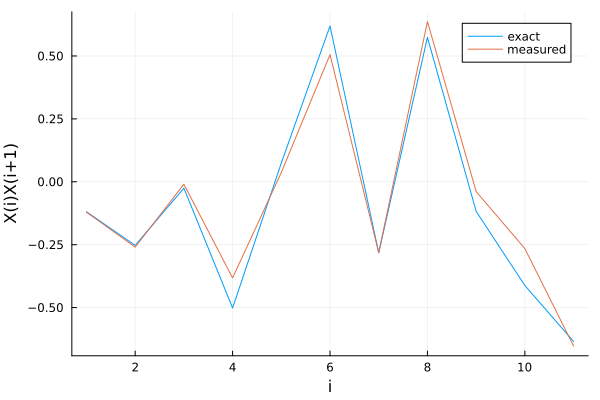

In [48]:

for i in 1:N-1
    O_exact[i] = real(inner(ψ',O[i],ψ))
end
using Plots
plot(O_exact,label="exact")
plot!(O_est,label="measured")
xlabel!("i")
ylabel!("X(i)X(i+1)")